In [1]:
import json

with open("model.json", mode="r") as f:
    d = json.load(f)

In [2]:
TOPIC_ORDER = ['Ambiance', 'Emplacement', 'Chambre', 'Rapport qualité-prix', 'Personnel']

In [3]:
data = {key: {t: [] for t in TOPIC_ORDER} for key in d.keys()}

for m, da in d.items():
    for a, dv in da.items():
        for v, dt in dv.items():
            for t, c in dt.items():
                data[m][t].append(c)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import pandas as pd

In [6]:
records = []
for model, topics in data.items():
    for topic, values in topics.items():
        arr = np.array(values)
        records.append((model, topic, arr.mean(), arr.std()))

# Turn into simpler arrays
models = [r[0] for r in records]
topics = [r[1] for r in records]
means = [r[2] for r in records]
stds = [r[3] for r in records]

rows = []
for model, topics in data.items():
    for topic, values in topics.items():
        for v in values:
            rows.append({
                "model": model,
                "topic": topic,
                "value": v
            })

df = pd.DataFrame(rows)

df = df[~df['model'].str.contains('1B|3B|keywords-|Llama-3.3-70B-Instruct-FP8')]



In [7]:
TRANSLATION_TOPICS = {
    "Rapport qualité-prix": "Value for Money",
    "Ambiance": "Ambience",
    "Chambre": "Room",
    "Emplacement": "Location",
    "Personnel": "Staff"
}

In [8]:
ALIAS_MODEL = {
    "Mistral-Small-3.2-24B-Instruct-2506": "Mistral-3.2-24B",
    "gemma-3-27b-it": "Gemma-3-27B",
    "gemma-3-12b-it": "Gemma-3-12B",
    "Llama-3.1-8B-Instruct": "Llama-3.1-8B",
    "Mistral-Nemo-Instruct-FP8-2407": "Mistral-Nemo-12B",
    "Ministral-8B-Instruct-2410": "Ministral-8B",
    "Llama-3.3-70B-Instruct": "Llama-3.3-70B"
}

In [9]:
# Apply ALIAS_MODEL to the 'Model' column
df['model'] = df['model'].map(ALIAS_MODEL).fillna(df['model'])

# Apply TRANSLATION_TOPICS to the 'Topic' column
df['topic'] = df['topic'].map(TRANSLATION_TOPICS).fillna(df['topic'])

In [10]:
df.rename(columns={"model": "Model"}, inplace=True)

In [11]:
import pandas as pd

In [12]:
df

,Model,topic,value
130,Mistral-3.2-24B,Ambience,217
131,Mistral-3.2-24B,Ambience,190
132,Mistral-3.2-24B,Ambience,295
133,Mistral-3.2-24B,Ambience,283
134,Mistral-3.2-24B,Ambience,285
...,...,...,...
1295,Mistral-Nemo-12B,Staff,623
1296,Mistral-Nemo-12B,Staff,665
1297,Mistral-Nemo-12B,Staff,611
1298,Mistral-Nemo-12B,Staff,617


/tmp/ipykernel_38012/1635852706.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
/tmp/ipykernel_38012/1635852706.py:20: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.barplot(
/tmp/ipykernel_38012/1635852706.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  topic_stats = df.groupby("topic")["value"].agg(["mean", "std"])


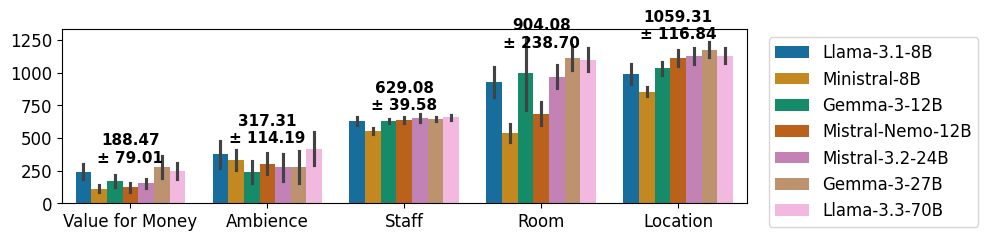

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example TOPIC_ORDER

# Ensure topic is categorical with your desired order
df['topic'] = pd.Categorical(df['topic'], categories=['Value for Money','Ambience', 'Staff', 'Room', 'Location'], ordered=True)

# Sort models by size (assuming names like Model-12B, Model-6B, etc.)
def extract_size(model_name):
    # Extract numeric part before 'B'
    return int(model_name.split('-')[-1].replace('B',''))

model_order = sorted(df['Model'].unique(), key=extract_size)
df['Model'] = pd.Categorical(df['Model'], categories=model_order, ordered=True)

plt.figure(figsize=(10, 2.5))

sns.barplot(
    data=df,
    x="topic",
    y="value",
    hue="Model",
    ci="sd",
    palette=sns.color_palette("colorblind"),
)

ax = plt.gca()

# Compute mean and std per topic (across all models)
topic_stats = df.groupby("topic")["value"].agg(["mean", "std"])

topics = list(df['topic'].cat.categories)
models = list(df['Model'].cat.categories)

num_topics = len(topics)
num_models = len(models)

# Loop through topics
for t_idx, topic in enumerate(topics):

    # Retrieve patches corresponding to this topic across all models
    topic_patches = []
    for m_idx in range(num_models):
        patch_index = m_idx * num_topics + t_idx
        topic_patches.append(ax.patches[patch_index])

    # Midpoint of the topic's grouped bars
    xs = [p.get_x() + p.get_width() / 2 for p in topic_patches]
    mid_x = sum(xs) / len(xs)

    # Maximum bar height in the group
    max_y = max([p.get_height() for p in topic_patches])

    mean_val = topic_stats.loc[topic, "mean"]
    std_val  = topic_stats.loc[topic, "std"]

    # Add text label (mean ± std)
    ax.text(
        mid_x,
        max_y * 1.05,
        f"{mean_val:.2f}\n± {std_val:.2f}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold"
    )

plt.xticks(fontsize=12)  # X-axis labels
plt.yticks(fontsize=12)               # Y-axis labels
plt.xlabel("", fontsize=14)           # X-axis title
plt.ylabel("", fontsize=14)           # Y-axis title

# Legend outside on the right
plt.legend(title="", loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=12, title_fontsize=14)

plt.tight_layout()
plt.savefig('count.png', dpi=300, bbox_inches='tight')  # bbox_inches to include legend
plt.show()
